# Finetuning hyperparmeters for the neural nets  

In [35]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle

print(tf.__version__)
print(keras.__version__)

#Is GPU available
print("GPU available: ", tf.test.is_gpu_available())


2.1.0
2.2.4-tf


In [36]:
#Load data
fashion_mnist =keras.datasets.fashion_mnist

(X_train_full,y_train_full),(X_test,y_test)= fashion_mnist.load_data()

print(X_train_full.shape)
print(X_test.shape)



(60000, 28, 28)
(10000, 28, 28)


In [37]:
# Create the validation dataset
percent_samples = 20
total_samples = X_train_full.shape[0]

num_validation_samples =int(total_samples * percent_samples / 100)

print("Num validation samples: {}".format(num_validation_samples))
print("Total training samples: {}".format(total_samples))

#Get shuffled indices
a = np.arange(total_samples)
shuffled_idx =shuffle(a)

#Create validation indices
idx_val =shuffled_idx[:num_validation_samples]

#Create trainng indices
idx_training =shuffled_idx[num_validation_samples:]

#Slice the dataset and normalize it to 0 - 1
X_train, X_valid = X_train_full[idx_training] / 255.0, X_train_full[idx_val] / 255.0
y_train, y_valid = y_train_full[idx_training], y_train_full[idx_val]


#Specify the class names
class_names = ["tshirt", "trouser", "Pullover","Dress","Coat","Sandat","Shirt","Sneaker","Bag","Ankle boot"]


# Create size variables
num_training_samples = X_train.shape[0]
num_validation_samples = X_valid.shape[0]
num_test_samples = X_test.shape[0]
num_classes = np.unique(y_train).shape[0]

#Display info
print("num_training_samples: {}".format(num_training_samples))
print("num_validation_samples: {}".format(num_validation_samples))
print("num_test_samples: {}".format(num_test_samples))
print("num_classes: {}".format(num_classes))


Num validation samples: 12000
Total training samples: 60000
num_training_samples: 48000
num_validation_samples: 12000
num_test_samples: 10000
num_classes: 10


Showing training data on grid of rows=4, cols=3


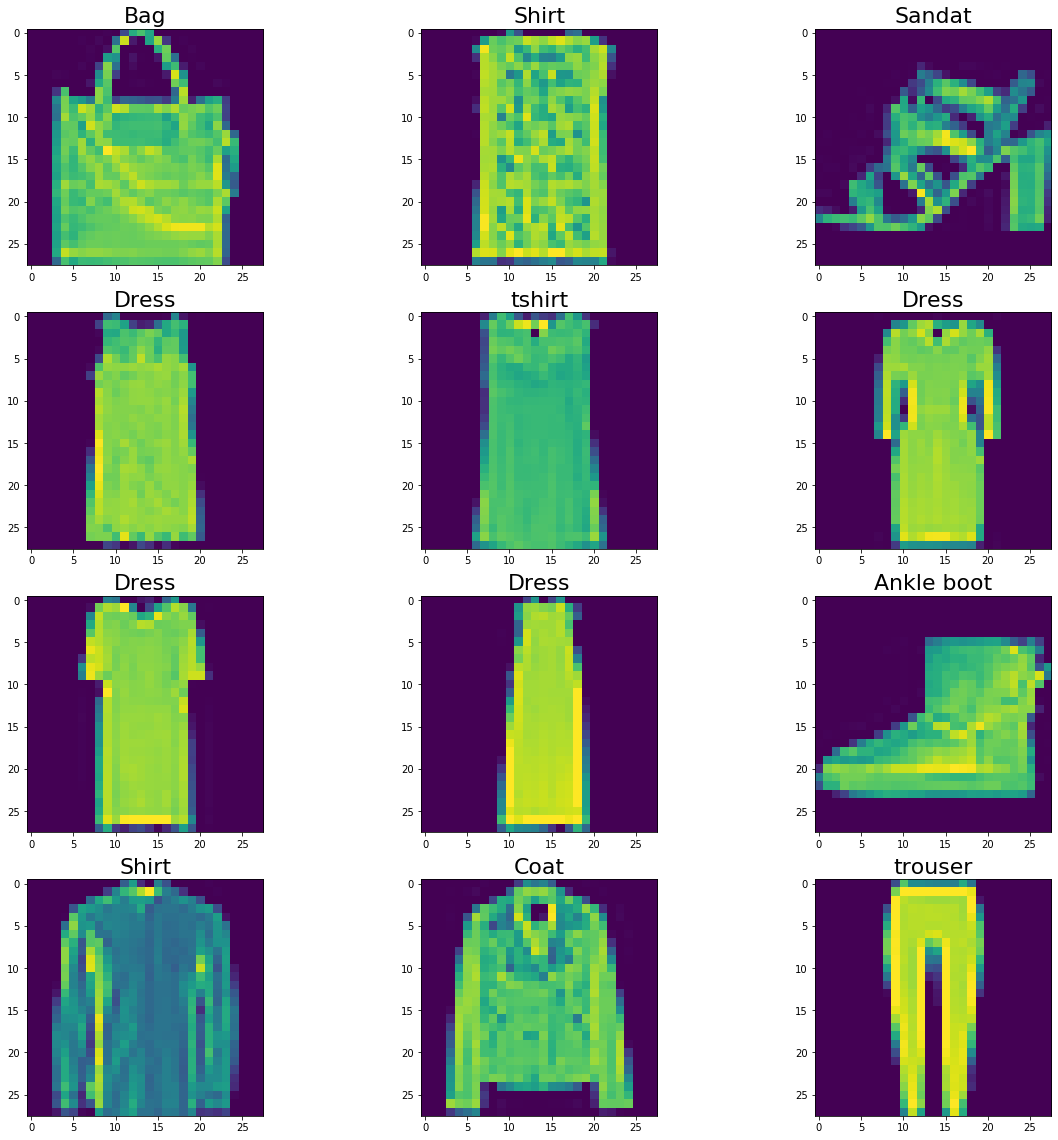

In [38]:
## Data exploration
num_show_samples=12
idx_show = random.sample(range(num_training_samples),num_show_samples)

rows = 4
cols = int(np.ceil(num_show_samples/rows))
print("Showing training data on grid of rows={}, cols={}".format(rows,cols))

plt.figure(figsize=(20,20))
for i in range(num_show_samples):
    ax = plt.subplot(rows,cols,i+1)
    plt.imshow(X_train[idx_show[i]])
    plt.title("{}".format(class_names[y_train[idx_show[i]]]), fontsize=22)


## Are the classes well represented?

In this case, seems like the classes are well represented. If that wasn't the case, you could augment the data, and/or, use class_weights in the Sequential API for assigning more/less weight to certain classes based on their frequency

['tshirt', 'trouser', 'Pullover', 'Dress', 'Coat', 'Sandat', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


[Text(0, 0, 'tshirt'),
 Text(0, 0, 'trouser'),
 Text(0, 0, 'Pullover'),
 Text(0, 0, 'Dress'),
 Text(0, 0, 'Coat'),
 Text(0, 0, 'Sandat'),
 Text(0, 0, 'Shirt'),
 Text(0, 0, 'Sneaker'),
 Text(0, 0, 'Bag'),
 Text(0, 0, 'Ankle boot')]

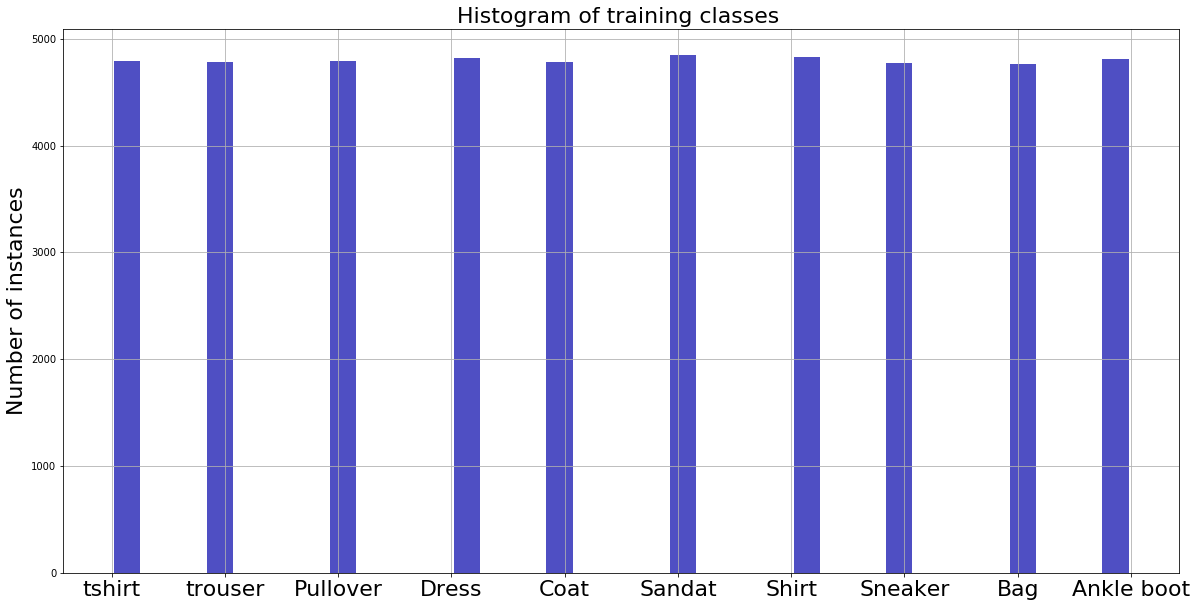

In [40]:
# Are the classes well represented?
plt.figure(figsize=(20,10))

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(y_train, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

plt.title("Histogram of training classes ", fontsize=22)
plt.grid('on')
plt.ylabel("Number of instances", fontsize=22)

xtick_labels = class_names
print(xtick_labels)

# # now, define the ticks (i.e. locations where the labels will be plotted)
xticks = [i for i in range(num_classes)]

# # also define the labels we'll use (note this MUST have the same size as `xticks`!)
# xtick_labels = ['Family-%d' % (f+1) for f in range(NUM_FAMILIES)]

ax = plt.gca()
# add the ticks and labels to the plot
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels,fontsize=22)


## Callbacks for the model 
### Note: Unable to get launch tensorboard with right directory from the notebook on Windows. Instead, just start tensorboard from the command line externally


In [44]:
# Use save Modelcheckpoint callback so that I have intermediate versions of the trained model before the training has completed.
    #Byt default, this saves model at end of each epoch, but callbacks can be called at 
    # start/end of epoch, start/end of each batch, start/end of training 

#Use EarlyStopping to reduce resource usage.

import os

model_folder_name = "mlp_hyperparam_tuning"
model_name = model_folder_name + ".h5"


#ModelCheckpoint - Save only the best model
save_model_filepath = os.path.join(os.pardir,"models",model_folder_name,model_name)

print("ModelCheckpoint Callback saves the model in: {}".format(save_model_filepath))

checkpoint_cb = keras.callbacks.ModelCheckpoint(save_model_filepath,
                                               save_best_only=True)

# Early stopping.
# ModelCheckpoint will save best, but wont stop training, which might go on for a long time and consume resources.
# Early stoppoing callback helps with this
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                      patience=10,
#                                                      restore_best_weights=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

#Create a custom callback if needed. For example, display the ratio of validation loss / training_loss to detect overfitting
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        print("\n Custom Callback - Epoch: {}, val/train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))

#Instance of the custom callback
print_ratio_cb = PrintValTrainRatioCallback()


#Tensorboard callback

#Note:
#For windows, forward and back slahses are painful to get right for the tensorboard usage.
# What works is that create a windows path, and replace the \ with \\

#Save data in models folder.
root_logdir = os.path.join(os.pardir, "models", model_folder_name, "tensorboard", "my_logs")
print("Tensorboard parent logs folder: {}".format(root_logdir))

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)

run_logdir = get_run_logdir()
print("Current logdir: {}".format(run_logdir))

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
# tensorboard_cb = keras.callbacks.TensorBoard("C:/Users/abhat/research/Tensorflow_2.0_tutorials/models/mlp_basic/tensorboard/my_logs")

# print("Note: Unable to get launch tensorboard with right directory from the notebook on Windows." 
#       "Instead, just start tensorboard from the command line externally")

#Note: Unable to get launch tensorboard with right directory from the notebook on Windows. 
#Instead, just start tensorboard from the command line externally

# print("Launching Tensorboard for visualization...")
# %load_ext tensorboard
# %tensorboard --logdir=run_logdir --port=6006
# %tensorboard --logdir="C:\Users\abhat\research\Tensorflow_2.0_tutorials\models\mlp_basic\tensorboard\my_logs" --port=6006


ModelCheckpoint Callback saves the model in: ..\models\mlp_hyperparam_tuning\mlp_hyperparam_tuning.h5
Tensorboard parent logs folder: ..\models\mlp_hyperparam_tuning\tensorboard\my_logs
Current logdir: ..\models\mlp_hyperparam_tuning\tensorboard\my_logs\run_2020_03_01_19_30_28


In [45]:
# Create a function that will return a Sequential model
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[28,28]):

    model = keras.models.Sequential(name="hyp_tuning_mlp")
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    model.add(keras.layers.Flatten())
    #Add the hidden layers
    for i in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons,activation='relu'))
    
    model.add(keras.layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                 metrics=["accuracy"])
        
    return model


model = build_model()
model.summary()



Model: "hyp_tuning_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 30)                23550     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
_________________________________________________________________


## Create a Keras regressor and use randomized search for testing various hyperparameters


In [47]:

#Create a KerasRegressor based on the build_model()
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

# keras_reg.fit(X_train,y_train,epochs=10,
#                   validation_data=(X_valid,y_valid))

# Create the RandomizedSearchCV 
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs ={
    "n_hidden"  : [0, 1 , 2, 3],
    "n_neurons" : [10, 30, 50],
    "learning_rate" : reciprocal(3e-4, 3e-2),    
}


rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs,n_iter=10,cv=3)
rnd_search_cv.fit(X_train,y_train,epochs=100,
                  validation_data=(X_valid,y_valid),
                 callbacks=[checkpoint_cb, early_stopping_cb, print_ratio_cb, tensorboard_cb])


Train on 32000 samples, validate on 12000 samples
Epoch 1/100
31648/32000 [============================>.] - ETA: 0s - loss: 1.0007 - accuracy: 0.6712
 Custom Callback - Epoch: 0, val/train loss ratio: 0.66
32000/32000 [==============================] - 5s 168us/sample - loss: 0.9965 - accuracy: 0.6727 - val_loss: 0.6620 - val_accuracy: 0.7644
Epoch 2/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.5856 - accuracy: 0.7969
 Custom Callback - Epoch: 1, val/train loss ratio: 0.91
32000/32000 [==============================] - 5s 144us/sample - loss: 0.5844 - accuracy: 0.7974 - val_loss: 0.5336 - val_accuracy: 0.8168
Epoch 3/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.5172 - accuracy: 0.8202
 Custom Callback - Epoch: 2, val/train loss ratio: 0.95
32000/32000 [==============================] - 5s 145us/sample - loss: 0.5171 - accuracy: 0.8200 - val_loss: 0.4929 - val_accuracy: 0.8301
Epoch 4/100
31680/32000 [============================>.] - ETA

16000/16000 [==============================] - 1s 67us/sample - loss: 0.3593 - accuracy: 0.8754
Train on 32000 samples, validate on 12000 samples
Epoch 1/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.9464 - accuracy: 0.6872
 Custom Callback - Epoch: 0, val/train loss ratio: 0.68
32000/32000 [==============================] - 5s 152us/sample - loss: 0.9451 - accuracy: 0.6876 - val_loss: 0.6454 - val_accuracy: 0.7821
Epoch 2/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.5801 - accuracy: 0.8015
 Custom Callback - Epoch: 1, val/train loss ratio: 0.92
32000/32000 [==============================] - 5s 148us/sample - loss: 0.5792 - accuracy: 0.8014 - val_loss: 0.5342 - val_accuracy: 0.8224
Epoch 3/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.5083 - accuracy: 0.8248
 Custom Callback - Epoch: 2, val/train loss ratio: 0.96
32000/32000 [==============================] - 5s 142us/sample - loss: 0.5083 - accuracy: 0.8249 - val_lo

31584/32000 [============================>.] - ETA: 0s - loss: 0.3598 - accuracy: 0.8729
 Custom Callback - Epoch: 16, val/train loss ratio: 1.13
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3602 - accuracy: 0.8727 - val_loss: 0.4062 - val_accuracy: 0.8595
Epoch 18/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.3559 - accuracy: 0.8747
 Custom Callback - Epoch: 17, val/train loss ratio: 1.14
32000/32000 [==============================] - 5s 141us/sample - loss: 0.3557 - accuracy: 0.8747 - val_loss: 0.4041 - val_accuracy: 0.8594
Epoch 19/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.3511 - accuracy: 0.8764
 Custom Callback - Epoch: 18, val/train loss ratio: 1.09
32000/32000 [==============================] - 5s 141us/sample - loss: 0.3510 - accuracy: 0.8764 - val_loss: 0.3810 - val_accuracy: 0.8706
Epoch 20/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.3455 - accuracy: 0.8758
 Custom Callback 

Epoch 36/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.4977 - accuracy: 0.8304
 Custom Callback - Epoch: 35, val/train loss ratio: 1.02
32000/32000 [==============================] - 5s 143us/sample - loss: 0.4973 - accuracy: 0.8306 - val_loss: 0.5096 - val_accuracy: 0.8263
Epoch 37/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.4943 - accuracy: 0.8311
 Custom Callback - Epoch: 36, val/train loss ratio: 1.02
32000/32000 [==============================] - 5s 143us/sample - loss: 0.4947 - accuracy: 0.8310 - val_loss: 0.5065 - val_accuracy: 0.8278
Epoch 38/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.4926 - accuracy: 0.8322
 Custom Callback - Epoch: 37, val/train loss ratio: 1.02
32000/32000 [==============================] - 5s 142us/sample - loss: 0.4919 - accuracy: 0.8324 - val_loss: 0.5039 - val_accuracy: 0.8298
Epoch 39/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4888 - accuracy: 0.8332
 Cus

Epoch 64/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.4455 - accuracy: 0.8467
 Custom Callback - Epoch: 63, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4457 - accuracy: 0.8466 - val_loss: 0.4630 - val_accuracy: 0.8427
Epoch 65/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4447 - accuracy: 0.8456
 Custom Callback - Epoch: 64, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4445 - accuracy: 0.8457 - val_loss: 0.4624 - val_accuracy: 0.8421
Epoch 66/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.4429 - accuracy: 0.8477
 Custom Callback - Epoch: 65, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4434 - accuracy: 0.8475 - val_loss: 0.4619 - val_accuracy: 0.8418
Epoch 67/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.4410 - accuracy: 0.8471
 Cus

Epoch 92/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.4171 - accuracy: 0.8550
 Custom Callback - Epoch: 91, val/train loss ratio: 1.06
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4175 - accuracy: 0.8552 - val_loss: 0.4419 - val_accuracy: 0.8485
Epoch 93/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.4172 - accuracy: 0.8534
 Custom Callback - Epoch: 92, val/train loss ratio: 1.06
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4170 - accuracy: 0.8536 - val_loss: 0.4416 - val_accuracy: 0.8472
Epoch 94/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.4155 - accuracy: 0.8561
 Custom Callback - Epoch: 93, val/train loss ratio: 1.06
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4157 - accuracy: 0.8560 - val_loss: 0.4420 - val_accuracy: 0.8473
Epoch 95/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.4151 - accuracy: 0.8556
 Cus

Epoch 47/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.4709 - accuracy: 0.8390
 Custom Callback - Epoch: 46, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 138us/sample - loss: 0.4714 - accuracy: 0.8387 - val_loss: 0.4875 - val_accuracy: 0.8338
Epoch 48/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.4694 - accuracy: 0.8395
 Custom Callback - Epoch: 47, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4694 - accuracy: 0.8395 - val_loss: 0.4857 - val_accuracy: 0.8338
Epoch 49/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.4684 - accuracy: 0.8398
 Custom Callback - Epoch: 48, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 138us/sample - loss: 0.4677 - accuracy: 0.8400 - val_loss: 0.4835 - val_accuracy: 0.8346
Epoch 50/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.4656 - accuracy: 0.8404
 Cus

Epoch 75/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.4340 - accuracy: 0.8505
 Custom Callback - Epoch: 74, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4336 - accuracy: 0.8505 - val_loss: 0.4541 - val_accuracy: 0.8457
Epoch 76/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.4328 - accuracy: 0.8504
 Custom Callback - Epoch: 75, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4326 - accuracy: 0.8506 - val_loss: 0.4536 - val_accuracy: 0.8466
Epoch 77/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.4312 - accuracy: 0.8513
 Custom Callback - Epoch: 76, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4317 - accuracy: 0.8512 - val_loss: 0.4537 - val_accuracy: 0.8462
Epoch 78/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.4301 - accuracy: 0.8512
 Cus

31936/32000 [============================>.] - ETA: 0s - loss: 1.3175 - accuracy: 0.6473
 Custom Callback - Epoch: 1, val/train loss ratio: 0.87
32000/32000 [==============================] - 4s 136us/sample - loss: 1.3174 - accuracy: 0.6472 - val_loss: 1.1486 - val_accuracy: 0.6757
Epoch 3/100
31488/32000 [============================>.] - ETA: 0s - loss: 1.0511 - accuracy: 0.6882
 Custom Callback - Epoch: 2, val/train loss ratio: 0.93
32000/32000 [==============================] - 4s 137us/sample - loss: 1.0499 - accuracy: 0.6885 - val_loss: 0.9729 - val_accuracy: 0.7021
Epoch 4/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.9206 - accuracy: 0.7082
 Custom Callback - Epoch: 3, val/train loss ratio: 0.96
32000/32000 [==============================] - 4s 137us/sample - loss: 0.9193 - accuracy: 0.7083 - val_loss: 0.8801 - val_accuracy: 0.7204
Epoch 5/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.8429 - accuracy: 0.7256
 Custom Callback - Epoc

Epoch 30/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.5110 - accuracy: 0.8263
 Custom Callback - Epoch: 29, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 136us/sample - loss: 0.5108 - accuracy: 0.8264 - val_loss: 0.5218 - val_accuracy: 0.8226
Epoch 31/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.5081 - accuracy: 0.8279
 Custom Callback - Epoch: 30, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 136us/sample - loss: 0.5076 - accuracy: 0.8283 - val_loss: 0.5174 - val_accuracy: 0.8249
Epoch 32/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.5043 - accuracy: 0.8289
 Custom Callback - Epoch: 31, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 136us/sample - loss: 0.5040 - accuracy: 0.8289 - val_loss: 0.5141 - val_accuracy: 0.8273
Epoch 33/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.5011 - accuracy: 0.8297
 Cus

Epoch 58/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.4505 - accuracy: 0.8459
 Custom Callback - Epoch: 57, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4496 - accuracy: 0.8462 - val_loss: 0.4655 - val_accuracy: 0.8414
Epoch 59/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.4480 - accuracy: 0.8460
 Custom Callback - Epoch: 58, val/train loss ratio: 1.03
32000/32000 [==============================] - 4s 138us/sample - loss: 0.4483 - accuracy: 0.8457 - val_loss: 0.4636 - val_accuracy: 0.8432
Epoch 60/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4473 - accuracy: 0.8461
 Custom Callback - Epoch: 59, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 138us/sample - loss: 0.4471 - accuracy: 0.8462 - val_loss: 0.4646 - val_accuracy: 0.8408
Epoch 61/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.4454 - accuracy: 0.8471
 Cus

Epoch 86/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.4198 - accuracy: 0.8558
 Custom Callback - Epoch: 85, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4201 - accuracy: 0.8558 - val_loss: 0.4414 - val_accuracy: 0.8507
Epoch 87/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4193 - accuracy: 0.8555
 Custom Callback - Epoch: 86, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4193 - accuracy: 0.8556 - val_loss: 0.4400 - val_accuracy: 0.8496
Epoch 88/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.4184 - accuracy: 0.8563
 Custom Callback - Epoch: 87, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 137us/sample - loss: 0.4185 - accuracy: 0.8563 - val_loss: 0.4395 - val_accuracy: 0.8511
Epoch 89/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4174 - accuracy: 0.8570
 Cus

Epoch 41/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.3135 - accuracy: 0.8894
 Custom Callback - Epoch: 40, val/train loss ratio: 1.18
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3133 - accuracy: 0.8895 - val_loss: 0.3698 - val_accuracy: 0.8732
Epoch 42/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8908
 Custom Callback - Epoch: 41, val/train loss ratio: 1.21
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3111 - accuracy: 0.8910 - val_loss: 0.3779 - val_accuracy: 0.8709
Epoch 43/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.3075 - accuracy: 0.8936
 Custom Callback - Epoch: 42, val/train loss ratio: 1.21
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3079 - accuracy: 0.8932 - val_loss: 0.3715 - val_accuracy: 0.8728
Epoch 44/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.8931
 Cus

Epoch 50/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.3002 - accuracy: 0.8951
 Custom Callback - Epoch: 49, val/train loss ratio: 1.21
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3002 - accuracy: 0.8951 - val_loss: 0.3645 - val_accuracy: 0.8727
Epoch 51/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.2966 - accuracy: 0.8958
 Custom Callback - Epoch: 50, val/train loss ratio: 1.29
32000/32000 [==============================] - 4s 136us/sample - loss: 0.2965 - accuracy: 0.8959 - val_loss: 0.3820 - val_accuracy: 0.8681
Epoch 52/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.2960 - accuracy: 0.8960
 Custom Callback - Epoch: 51, val/train loss ratio: 1.23
32000/32000 [==============================] - 4s 136us/sample - loss: 0.2960 - accuracy: 0.8961 - val_loss: 0.3640 - val_accuracy: 0.8741
Epoch 53/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.2941 - accuracy: 0.8979
 Cus

Epoch 52/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.2935 - accuracy: 0.8976
 Custom Callback - Epoch: 51, val/train loss ratio: 1.27
32000/32000 [==============================] - 4s 136us/sample - loss: 0.2935 - accuracy: 0.8976 - val_loss: 0.3716 - val_accuracy: 0.8702
Epoch 53/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.2901 - accuracy: 0.8988
 Custom Callback - Epoch: 52, val/train loss ratio: 1.24
32000/32000 [==============================] - 4s 136us/sample - loss: 0.2910 - accuracy: 0.8984 - val_loss: 0.3606 - val_accuracy: 0.8758
Epoch 54/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.2897 - accuracy: 0.8981
 Custom Callback - Epoch: 53, val/train loss ratio: 1.26
32000/32000 [==============================] - 4s 136us/sample - loss: 0.2897 - accuracy: 0.8981 - val_loss: 0.3642 - val_accuracy: 0.8736
Epoch 55/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.2884 - accuracy: 0.8990
 Cus

Epoch 49/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.4199 - accuracy: 0.8543
 Custom Callback - Epoch: 48, val/train loss ratio: 1.07
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4209 - accuracy: 0.8541 - val_loss: 0.4515 - val_accuracy: 0.8473
Epoch 50/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.4204 - accuracy: 0.8544
 Custom Callback - Epoch: 49, val/train loss ratio: 1.06
32000/32000 [==============================] - 5s 143us/sample - loss: 0.4206 - accuracy: 0.8545 - val_loss: 0.4462 - val_accuracy: 0.8493
Epoch 51/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.4189 - accuracy: 0.8566
 Custom Callback - Epoch: 50, val/train loss ratio: 1.07
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4191 - accuracy: 0.8565 - val_loss: 0.4472 - val_accuracy: 0.8500
Epoch 52/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4180 - accuracy: 0.8550
 Cus

Epoch 77/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.3981 - accuracy: 0.8626
 Custom Callback - Epoch: 76, val/train loss ratio: 1.09
32000/32000 [==============================] - 4s 135us/sample - loss: 0.3985 - accuracy: 0.8622 - val_loss: 0.4326 - val_accuracy: 0.8533
Epoch 78/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.3978 - accuracy: 0.8630
 Custom Callback - Epoch: 77, val/train loss ratio: 1.10
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3974 - accuracy: 0.8631 - val_loss: 0.4373 - val_accuracy: 0.8519
Epoch 79/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.3957 - accuracy: 0.8636
 Custom Callback - Epoch: 78, val/train loss ratio: 1.09
32000/32000 [==============================] - 4s 137us/sample - loss: 0.3963 - accuracy: 0.8635 - val_loss: 0.4327 - val_accuracy: 0.8537
Epoch 80/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.3965 - accuracy: 0.8629
 Cus

31840/32000 [============================>.] - ETA: 0s - loss: 0.6831 - accuracy: 0.7626
 Custom Callback - Epoch: 3, val/train loss ratio: 0.98
32000/32000 [==============================] - 4s 137us/sample - loss: 0.6834 - accuracy: 0.7622 - val_loss: 0.6667 - val_accuracy: 0.7710
Epoch 5/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.6420 - accuracy: 0.7740
 Custom Callback - Epoch: 4, val/train loss ratio: 0.99
32000/32000 [==============================] - 4s 136us/sample - loss: 0.6420 - accuracy: 0.7739 - val_loss: 0.6366 - val_accuracy: 0.7747
Epoch 6/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.6128 - accuracy: 0.7828
 Custom Callback - Epoch: 5, val/train loss ratio: 1.00
32000/32000 [==============================] - 4s 136us/sample - loss: 0.6129 - accuracy: 0.7831 - val_loss: 0.6134 - val_accuracy: 0.7873
Epoch 7/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.5913 - accuracy: 0.7917
 Custom Callback - Epoc

Epoch 32/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.4430 - accuracy: 0.8457
 Custom Callback - Epoch: 31, val/train loss ratio: 1.06
32000/32000 [==============================] - 4s 135us/sample - loss: 0.4430 - accuracy: 0.8456 - val_loss: 0.4697 - val_accuracy: 0.8395
Epoch 33/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.4412 - accuracy: 0.8458
 Custom Callback - Epoch: 32, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4412 - accuracy: 0.8459 - val_loss: 0.4651 - val_accuracy: 0.8417
Epoch 34/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.4378 - accuracy: 0.8460
 Custom Callback - Epoch: 33, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4393 - accuracy: 0.8456 - val_loss: 0.4599 - val_accuracy: 0.8439
Epoch 35/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4371 - accuracy: 0.8474
 Cus

Epoch 60/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4047 - accuracy: 0.8599
 Custom Callback - Epoch: 59, val/train loss ratio: 1.08
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4046 - accuracy: 0.8599 - val_loss: 0.4367 - val_accuracy: 0.8512
Epoch 61/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4039 - accuracy: 0.8590
 Custom Callback - Epoch: 60, val/train loss ratio: 1.08
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4039 - accuracy: 0.8590 - val_loss: 0.4359 - val_accuracy: 0.8517
Epoch 62/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.4025 - accuracy: 0.8605
 Custom Callback - Epoch: 61, val/train loss ratio: 1.08
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4025 - accuracy: 0.8604 - val_loss: 0.4357 - val_accuracy: 0.8518
Epoch 63/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.4016 - accuracy: 0.8600
 Cus

Epoch 88/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8659
 Custom Callback - Epoch: 87, val/train loss ratio: 1.10
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3836 - accuracy: 0.8658 - val_loss: 0.4237 - val_accuracy: 0.8558
Epoch 89/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.3821 - accuracy: 0.8669
 Custom Callback - Epoch: 88, val/train loss ratio: 1.12
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3829 - accuracy: 0.8667 - val_loss: 0.4272 - val_accuracy: 0.8528
Epoch 90/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.3820 - accuracy: 0.8675
 Custom Callback - Epoch: 89, val/train loss ratio: 1.12
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3821 - accuracy: 0.8675 - val_loss: 0.4272 - val_accuracy: 0.8575
Epoch 91/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.3815 - accuracy: 0.8673
 Cus

Epoch 47/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.4353 - accuracy: 0.8473
 Custom Callback - Epoch: 46, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4352 - accuracy: 0.8473 - val_loss: 0.4540 - val_accuracy: 0.8442
Epoch 48/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4334 - accuracy: 0.8475
 Custom Callback - Epoch: 47, val/train loss ratio: 1.05
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4333 - accuracy: 0.8475 - val_loss: 0.4532 - val_accuracy: 0.8453
Epoch 49/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.4325 - accuracy: 0.8476
 Custom Callback - Epoch: 48, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4321 - accuracy: 0.8478 - val_loss: 0.4491 - val_accuracy: 0.8463
Epoch 50/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.4304 - accuracy: 0.8491
 Cus

Epoch 75/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.4023 - accuracy: 0.8587
 Custom Callback - Epoch: 74, val/train loss ratio: 1.06
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4014 - accuracy: 0.8587 - val_loss: 0.4265 - val_accuracy: 0.8544
Epoch 76/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4007 - accuracy: 0.8594
 Custom Callback - Epoch: 75, val/train loss ratio: 1.07
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4008 - accuracy: 0.8593 - val_loss: 0.4288 - val_accuracy: 0.8545
Epoch 77/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.3997 - accuracy: 0.8602
 Custom Callback - Epoch: 76, val/train loss ratio: 1.09
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3998 - accuracy: 0.8601 - val_loss: 0.4345 - val_accuracy: 0.8497
Epoch 78/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.3996 - accuracy: 0.8593
 Cus

31488/32000 [============================>.] - ETA: 0s - loss: 0.6328 - accuracy: 0.7807
 Custom Callback - Epoch: 1, val/train loss ratio: 0.91
32000/32000 [==============================] - 5s 142us/sample - loss: 0.6329 - accuracy: 0.7805 - val_loss: 0.5769 - val_accuracy: 0.8065
Epoch 3/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.5455 - accuracy: 0.8094
 Custom Callback - Epoch: 2, val/train loss ratio: 0.96
32000/32000 [==============================] - 5s 141us/sample - loss: 0.5454 - accuracy: 0.8094 - val_loss: 0.5229 - val_accuracy: 0.8273
Epoch 4/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.5049 - accuracy: 0.8244
 Custom Callback - Epoch: 3, val/train loss ratio: 0.96
32000/32000 [==============================] - 5s 144us/sample - loss: 0.5046 - accuracy: 0.8244 - val_loss: 0.4861 - val_accuracy: 0.8329
Epoch 5/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.4775 - accuracy: 0.8322
 Custom Callback - Epoc

16000/16000 [==============================] - 1s 69us/sample - loss: 0.3792 - accuracy: 0.8692
Train on 32000 samples, validate on 12000 samples
Epoch 1/100
31520/32000 [============================>.] - ETA: 0s - loss: 1.1245 - accuracy: 0.6284
 Custom Callback - Epoch: 0, val/train loss ratio: 0.63
32000/32000 [==============================] - 5s 151us/sample - loss: 1.1187 - accuracy: 0.6303 - val_loss: 0.7062 - val_accuracy: 0.7473
Epoch 2/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.6242 - accuracy: 0.7785
 Custom Callback - Epoch: 1, val/train loss ratio: 0.95
32000/32000 [==============================] - 4s 141us/sample - loss: 0.6234 - accuracy: 0.7788 - val_loss: 0.5892 - val_accuracy: 0.7943
Epoch 3/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.5478 - accuracy: 0.8085
 Custom Callback - Epoch: 2, val/train loss ratio: 0.97
32000/32000 [==============================] - 5s 142us/sample - loss: 0.5483 - accuracy: 0.8083 - val_lo

31744/32000 [============================>.] - ETA: 0s - loss: 0.3679 - accuracy: 0.8681
 Custom Callback - Epoch: 17, val/train loss ratio: 1.10
32000/32000 [==============================] - 5s 141us/sample - loss: 0.3686 - accuracy: 0.8677 - val_loss: 0.4058 - val_accuracy: 0.8618
Epoch 19/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.3627 - accuracy: 0.8717
 Custom Callback - Epoch: 18, val/train loss ratio: 1.12
32000/32000 [==============================] - 4s 141us/sample - loss: 0.3624 - accuracy: 0.8719 - val_loss: 0.4065 - val_accuracy: 0.8593
Epoch 20/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.3605 - accuracy: 0.8713
 Custom Callback - Epoch: 19, val/train loss ratio: 1.09
32000/32000 [==============================] - 5s 141us/sample - loss: 0.3606 - accuracy: 0.8712 - val_loss: 0.3943 - val_accuracy: 0.8649
Epoch 21/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.3545 - accuracy: 0.8731
 Custom Callback 

Epoch 46/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.2862 - accuracy: 0.8980
 Custom Callback - Epoch: 45, val/train loss ratio: 1.32
32000/32000 [==============================] - 4s 140us/sample - loss: 0.2861 - accuracy: 0.8981 - val_loss: 0.3765 - val_accuracy: 0.8712
Epoch 47/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.2858 - accuracy: 0.8981
 Custom Callback - Epoch: 46, val/train loss ratio: 1.32
32000/32000 [==============================] - 4s 141us/sample - loss: 0.2857 - accuracy: 0.8981 - val_loss: 0.3780 - val_accuracy: 0.8667
Epoch 48/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.2836 - accuracy: 0.8980
 Custom Callback - Epoch: 47, val/train loss ratio: 1.31
32000/32000 [==============================] - 4s 140us/sample - loss: 0.2842 - accuracy: 0.8977 - val_loss: 0.3727 - val_accuracy: 0.8696
Epoch 49/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.2820 - accuracy: 0.8995
 Cus

16000/16000 [==============================] - 1s 66us/sample - loss: 0.3421 - accuracy: 0.8774
Train on 32000 samples, validate on 12000 samples
Epoch 1/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.6540 - accuracy: 0.7637
 Custom Callback - Epoch: 0, val/train loss ratio: 0.76
32000/32000 [==============================] - 5s 150us/sample - loss: 0.6520 - accuracy: 0.7645 - val_loss: 0.4937 - val_accuracy: 0.8254
Epoch 2/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.4514 - accuracy: 0.8352
 Custom Callback - Epoch: 1, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 140us/sample - loss: 0.4518 - accuracy: 0.8351 - val_loss: 0.4713 - val_accuracy: 0.8321
Epoch 3/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.4097 - accuracy: 0.8477
 Custom Callback - Epoch: 2, val/train loss ratio: 0.98
32000/32000 [==============================] - 4s 140us/sample - loss: 0.4096 - accuracy: 0.8477 - val_lo

Epoch 11/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.4799 - accuracy: 0.8305
 Custom Callback - Epoch: 10, val/train loss ratio: 1.03
32000/32000 [==============================] - 5s 141us/sample - loss: 0.4795 - accuracy: 0.8307 - val_loss: 0.4930 - val_accuracy: 0.8257
Epoch 12/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.4714 - accuracy: 0.8319
 Custom Callback - Epoch: 11, val/train loss ratio: 1.02
32000/32000 [==============================] - 5s 141us/sample - loss: 0.4710 - accuracy: 0.8322 - val_loss: 0.4809 - val_accuracy: 0.8303
Epoch 13/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4627 - accuracy: 0.8347
 Custom Callback - Epoch: 12, val/train loss ratio: 1.04
32000/32000 [==============================] - 4s 141us/sample - loss: 0.4626 - accuracy: 0.8348 - val_loss: 0.4801 - val_accuracy: 0.8316
Epoch 14/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.4553 - accuracy: 0.8392
 Cus

Epoch 39/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.3695 - accuracy: 0.8698
 Custom Callback - Epoch: 38, val/train loss ratio: 1.08
32000/32000 [==============================] - 5s 141us/sample - loss: 0.3696 - accuracy: 0.8697 - val_loss: 0.4006 - val_accuracy: 0.8620
Epoch 40/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.3673 - accuracy: 0.8711
 Custom Callback - Epoch: 39, val/train loss ratio: 1.10
32000/32000 [==============================] - 4s 141us/sample - loss: 0.3671 - accuracy: 0.8712 - val_loss: 0.4054 - val_accuracy: 0.8608
Epoch 41/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.3641 - accuracy: 0.8721
 Custom Callback - Epoch: 40, val/train loss ratio: 1.11
32000/32000 [==============================] - 4s 141us/sample - loss: 0.3646 - accuracy: 0.8717 - val_loss: 0.4058 - val_accuracy: 0.8593
Epoch 42/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.3637 - accuracy: 0.8728
 Cus

Epoch 67/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.3251 - accuracy: 0.8861
 Custom Callback - Epoch: 66, val/train loss ratio: 1.18
32000/32000 [==============================] - 4s 141us/sample - loss: 0.3250 - accuracy: 0.8861 - val_loss: 0.3829 - val_accuracy: 0.8672
Epoch 68/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.3238 - accuracy: 0.8864
 Custom Callback - Epoch: 67, val/train loss ratio: 1.17
32000/32000 [==============================] - 5s 141us/sample - loss: 0.3240 - accuracy: 0.8863 - val_loss: 0.3786 - val_accuracy: 0.8681
Epoch 69/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.3220 - accuracy: 0.8872
 Custom Callback - Epoch: 68, val/train loss ratio: 1.20
32000/32000 [==============================] - 4s 140us/sample - loss: 0.3225 - accuracy: 0.8872 - val_loss: 0.3878 - val_accuracy: 0.8638
Epoch 70/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.8868
 Cus

Epoch 37/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.3785 - accuracy: 0.8683
 Custom Callback - Epoch: 36, val/train loss ratio: 1.12
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3778 - accuracy: 0.8684 - val_loss: 0.4214 - val_accuracy: 0.8529
Epoch 38/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.3757 - accuracy: 0.8688
 Custom Callback - Epoch: 37, val/train loss ratio: 1.10
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3758 - accuracy: 0.8687 - val_loss: 0.4143 - val_accuracy: 0.8567
Epoch 39/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.3740 - accuracy: 0.8690
 Custom Callback - Epoch: 38, val/train loss ratio: 1.09
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3741 - accuracy: 0.8689 - val_loss: 0.4083 - val_accuracy: 0.8577
Epoch 40/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.3720 - accuracy: 0.8705
 Cus

Epoch 41/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.3839 - accuracy: 0.8652
 Custom Callback - Epoch: 40, val/train loss ratio: 1.08
32000/32000 [==============================] - 5s 146us/sample - loss: 0.3837 - accuracy: 0.8655 - val_loss: 0.4152 - val_accuracy: 0.8558
Epoch 42/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.3822 - accuracy: 0.8644
 Custom Callback - Epoch: 41, val/train loss ratio: 1.09
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3820 - accuracy: 0.8646 - val_loss: 0.4152 - val_accuracy: 0.8563
Epoch 43/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.3803 - accuracy: 0.8682
 Custom Callback - Epoch: 42, val/train loss ratio: 1.09
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3802 - accuracy: 0.8679 - val_loss: 0.4130 - val_accuracy: 0.8593
Epoch 44/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.3783 - accuracy: 0.8680
 Cus

31840/32000 [============================>.] - ETA: 0s - loss: 0.9727 - accuracy: 0.6783
 Custom Callback - Epoch: 2, val/train loss ratio: 0.88
32000/32000 [==============================] - 5s 141us/sample - loss: 0.9721 - accuracy: 0.6784 - val_loss: 0.8523 - val_accuracy: 0.7102
Epoch 4/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.7891 - accuracy: 0.7168
 Custom Callback - Epoch: 3, val/train loss ratio: 0.94
32000/32000 [==============================] - 5s 141us/sample - loss: 0.7890 - accuracy: 0.7168 - val_loss: 0.7398 - val_accuracy: 0.7337
Epoch 5/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.7089 - accuracy: 0.7435
 Custom Callback - Epoch: 4, val/train loss ratio: 0.96
32000/32000 [==============================] - 5s 141us/sample - loss: 0.7086 - accuracy: 0.7437 - val_loss: 0.6815 - val_accuracy: 0.7588
Epoch 6/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.7672
 Custom Callback - Epoc

Epoch 31/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.4432 - accuracy: 0.8438
 Custom Callback - Epoch: 30, val/train loss ratio: 1.04
32000/32000 [==============================] - 5s 141us/sample - loss: 0.4433 - accuracy: 0.8437 - val_loss: 0.4610 - val_accuracy: 0.8393
Epoch 32/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.4424 - accuracy: 0.8446
 Custom Callback - Epoch: 31, val/train loss ratio: 1.05
32000/32000 [==============================] - 5s 141us/sample - loss: 0.4421 - accuracy: 0.8448 - val_loss: 0.4629 - val_accuracy: 0.8388
Epoch 33/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4392 - accuracy: 0.8442
 Custom Callback - Epoch: 32, val/train loss ratio: 1.04
32000/32000 [==============================] - 5s 141us/sample - loss: 0.4395 - accuracy: 0.8443 - val_loss: 0.4572 - val_accuracy: 0.8400
Epoch 34/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.4375 - accuracy: 0.8459
 Cus

Epoch 59/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.3964 - accuracy: 0.8591
 Custom Callback - Epoch: 58, val/train loss ratio: 1.10
32000/32000 [==============================] - 4s 140us/sample - loss: 0.3965 - accuracy: 0.8591 - val_loss: 0.4380 - val_accuracy: 0.8482
Epoch 60/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.3955 - accuracy: 0.8617
 Custom Callback - Epoch: 59, val/train loss ratio: 1.12
32000/32000 [==============================] - 4s 141us/sample - loss: 0.3956 - accuracy: 0.8617 - val_loss: 0.4418 - val_accuracy: 0.8457
Epoch 61/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.3944 - accuracy: 0.8605
 Custom Callback - Epoch: 60, val/train loss ratio: 1.11
32000/32000 [==============================] - 5s 141us/sample - loss: 0.3948 - accuracy: 0.8604 - val_loss: 0.4364 - val_accuracy: 0.8466
Epoch 62/100
31776/32000 [============================>.] - ETA: 0s - loss: 0.3934 - accuracy: 0.8611
 Cus

Epoch 52/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.4016 - accuracy: 0.8599
 Custom Callback - Epoch: 51, val/train loss ratio: 1.09
32000/32000 [==============================] - 4s 140us/sample - loss: 0.4008 - accuracy: 0.8601 - val_loss: 0.4368 - val_accuracy: 0.8518
Epoch 53/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.3989 - accuracy: 0.8598
 Custom Callback - Epoch: 52, val/train loss ratio: 1.08
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3990 - accuracy: 0.8598 - val_loss: 0.4327 - val_accuracy: 0.8522
Epoch 54/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.3984 - accuracy: 0.8609
 Custom Callback - Epoch: 53, val/train loss ratio: 1.08
32000/32000 [==============================] - 4s 141us/sample - loss: 0.3985 - accuracy: 0.8608 - val_loss: 0.4323 - val_accuracy: 0.8523
Epoch 55/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.3967 - accuracy: 0.8613
 Cus

Epoch 80/100
31616/32000 [============================>.] - ETA: 0s - loss: 0.3741 - accuracy: 0.8689
 Custom Callback - Epoch: 79, val/train loss ratio: 1.12
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3743 - accuracy: 0.8688 - val_loss: 0.4188 - val_accuracy: 0.8585
Epoch 81/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.3732 - accuracy: 0.8692
 Custom Callback - Epoch: 80, val/train loss ratio: 1.13
32000/32000 [==============================] - 5s 141us/sample - loss: 0.3732 - accuracy: 0.8692 - val_loss: 0.4211 - val_accuracy: 0.8577
Epoch 82/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.3725 - accuracy: 0.8701
 Custom Callback - Epoch: 81, val/train loss ratio: 1.13
32000/32000 [==============================] - 4s 141us/sample - loss: 0.3723 - accuracy: 0.8702 - val_loss: 0.4214 - val_accuracy: 0.8568
Epoch 83/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.3708 - accuracy: 0.8691
 Cus

Epoch 45/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.4607 - accuracy: 0.8409
 Custom Callback - Epoch: 44, val/train loss ratio: 1.09
32000/32000 [==============================] - 5s 141us/sample - loss: 0.4605 - accuracy: 0.8409 - val_loss: 0.5041 - val_accuracy: 0.8256
Epoch 46/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.4585 - accuracy: 0.8420
 Custom Callback - Epoch: 45, val/train loss ratio: 1.09
32000/32000 [==============================] - 5s 141us/sample - loss: 0.4590 - accuracy: 0.8418 - val_loss: 0.4997 - val_accuracy: 0.8283
Epoch 47/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4564 - accuracy: 0.8439
 Custom Callback - Epoch: 46, val/train loss ratio: 1.07
32000/32000 [==============================] - 4s 140us/sample - loss: 0.4565 - accuracy: 0.8439 - val_loss: 0.4907 - val_accuracy: 0.8338
Epoch 48/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.4542 - accuracy: 0.8437
 Cus

Epoch 73/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.4147 - accuracy: 0.8564
 Custom Callback - Epoch: 72, val/train loss ratio: 1.10
32000/32000 [==============================] - 5s 144us/sample - loss: 0.4144 - accuracy: 0.8565 - val_loss: 0.4553 - val_accuracy: 0.8457
Epoch 74/100
31904/32000 [============================>.] - ETA: 0s - loss: 0.4126 - accuracy: 0.8568
 Custom Callback - Epoch: 73, val/train loss ratio: 1.11
32000/32000 [==============================] - 4s 139us/sample - loss: 0.4127 - accuracy: 0.8568 - val_loss: 0.4572 - val_accuracy: 0.8427
Epoch 75/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4127 - accuracy: 0.8579
 Custom Callback - Epoch: 74, val/train loss ratio: 1.10
32000/32000 [==============================] - 5s 141us/sample - loss: 0.4126 - accuracy: 0.8578 - val_loss: 0.4539 - val_accuracy: 0.8487
Epoch 76/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.4100 - accuracy: 0.8565
 Cus

31744/32000 [============================>.] - ETA: 0s - loss: 0.3721 - accuracy: 0.8648
 Custom Callback - Epoch: 18, val/train loss ratio: 1.13
32000/32000 [==============================] - 5s 141us/sample - loss: 0.3721 - accuracy: 0.8648 - val_loss: 0.4203 - val_accuracy: 0.8565
Epoch 20/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.3668 - accuracy: 0.8677
 Custom Callback - Epoch: 19, val/train loss ratio: 1.22
32000/32000 [==============================] - 5s 141us/sample - loss: 0.3671 - accuracy: 0.8676 - val_loss: 0.4476 - val_accuracy: 0.8434
Epoch 21/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.3672 - accuracy: 0.8680
 Custom Callback - Epoch: 20, val/train loss ratio: 1.17
32000/32000 [==============================] - 5s 142us/sample - loss: 0.3672 - accuracy: 0.8680 - val_loss: 0.4307 - val_accuracy: 0.8518
Epoch 22/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.3642 - accuracy: 0.8690
 Custom Callback 

Epoch 12/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.4915 - accuracy: 0.8321
 Custom Callback - Epoch: 11, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 136us/sample - loss: 0.4917 - accuracy: 0.8320 - val_loss: 0.4981 - val_accuracy: 0.8309
Epoch 13/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.4836 - accuracy: 0.8348
 Custom Callback - Epoch: 12, val/train loss ratio: 1.02
32000/32000 [==============================] - 4s 135us/sample - loss: 0.4837 - accuracy: 0.8346 - val_loss: 0.4944 - val_accuracy: 0.8323
Epoch 14/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.4759 - accuracy: 0.8361
 Custom Callback - Epoch: 13, val/train loss ratio: 1.01
32000/32000 [==============================] - 4s 135us/sample - loss: 0.4766 - accuracy: 0.8361 - val_loss: 0.4836 - val_accuracy: 0.8366
Epoch 15/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.4708 - accuracy: 0.8386
 Cus

Epoch 40/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8625
 Custom Callback - Epoch: 39, val/train loss ratio: 1.06
32000/32000 [==============================] - 4s 135us/sample - loss: 0.3950 - accuracy: 0.8623 - val_loss: 0.4180 - val_accuracy: 0.8581
Epoch 41/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.3931 - accuracy: 0.8628
 Custom Callback - Epoch: 40, val/train loss ratio: 1.06
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3928 - accuracy: 0.8631 - val_loss: 0.4176 - val_accuracy: 0.8585
Epoch 42/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.3913 - accuracy: 0.8640
 Custom Callback - Epoch: 41, val/train loss ratio: 1.07
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3911 - accuracy: 0.8641 - val_loss: 0.4166 - val_accuracy: 0.8587
Epoch 43/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.3900 - accuracy: 0.8635
 Cus

Epoch 68/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.3555 - accuracy: 0.8753
 Custom Callback - Epoch: 67, val/train loss ratio: 1.12
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3556 - accuracy: 0.8753 - val_loss: 0.3970 - val_accuracy: 0.8640
Epoch 69/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.3547 - accuracy: 0.8758
 Custom Callback - Epoch: 68, val/train loss ratio: 1.11
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3546 - accuracy: 0.8757 - val_loss: 0.3950 - val_accuracy: 0.8652
Epoch 70/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.3534 - accuracy: 0.8761
 Custom Callback - Epoch: 69, val/train loss ratio: 1.11
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3536 - accuracy: 0.8760 - val_loss: 0.3942 - val_accuracy: 0.8659
Epoch 71/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.3522 - accuracy: 0.8756
 Cus

Epoch 47/100
31456/32000 [============================>.] - ETA: 0s - loss: 0.3801 - accuracy: 0.8675
 Custom Callback - Epoch: 46, val/train loss ratio: 1.08
32000/32000 [==============================] - 4s 135us/sample - loss: 0.3800 - accuracy: 0.8674 - val_loss: 0.4111 - val_accuracy: 0.8602
Epoch 48/100
31680/32000 [============================>.] - ETA: 0s - loss: 0.3790 - accuracy: 0.8688
 Custom Callback - Epoch: 47, val/train loss ratio: 1.09
32000/32000 [==============================] - 4s 137us/sample - loss: 0.3785 - accuracy: 0.8689 - val_loss: 0.4132 - val_accuracy: 0.8607
Epoch 49/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.3756 - accuracy: 0.8700
 Custom Callback - Epoch: 48, val/train loss ratio: 1.09
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3769 - accuracy: 0.8695 - val_loss: 0.4101 - val_accuracy: 0.8611
Epoch 50/100
31520/32000 [============================>.] - ETA: 0s - loss: 0.3748 - accuracy: 0.8700
 Cus

Epoch 75/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.3448 - accuracy: 0.8800
 Custom Callback - Epoch: 74, val/train loss ratio: 1.15
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3452 - accuracy: 0.8798 - val_loss: 0.3968 - val_accuracy: 0.8643
Epoch 76/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.3441 - accuracy: 0.8814
 Custom Callback - Epoch: 75, val/train loss ratio: 1.14
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3442 - accuracy: 0.8813 - val_loss: 0.3915 - val_accuracy: 0.8662
Epoch 77/100
31968/32000 [============================>.] - ETA: 0s - loss: 0.3431 - accuracy: 0.8805
 Custom Callback - Epoch: 76, val/train loss ratio: 1.13
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3430 - accuracy: 0.8805 - val_loss: 0.3888 - val_accuracy: 0.8685
Epoch 78/100
31424/32000 [============================>.] - ETA: 0s - loss: 0.3421 - accuracy: 0.8809
 Cus

Epoch 38/100
31808/32000 [============================>.] - ETA: 0s - loss: 0.3934 - accuracy: 0.8640
 Custom Callback - Epoch: 37, val/train loss ratio: 1.06
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3936 - accuracy: 0.8639 - val_loss: 0.4169 - val_accuracy: 0.8579
Epoch 39/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.3924 - accuracy: 0.8638
 Custom Callback - Epoch: 38, val/train loss ratio: 1.06
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3921 - accuracy: 0.8641 - val_loss: 0.4152 - val_accuracy: 0.8587
Epoch 40/100
31552/32000 [============================>.] - ETA: 0s - loss: 0.3892 - accuracy: 0.8657
 Custom Callback - Epoch: 39, val/train loss ratio: 1.07
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3897 - accuracy: 0.8658 - val_loss: 0.4157 - val_accuracy: 0.8587
Epoch 41/100
31712/32000 [============================>.] - ETA: 0s - loss: 0.3882 - accuracy: 0.8663
 Cus

Epoch 66/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.3547 - accuracy: 0.8782
 Custom Callback - Epoch: 65, val/train loss ratio: 1.10
32000/32000 [==============================] - 4s 135us/sample - loss: 0.3550 - accuracy: 0.8781 - val_loss: 0.3901 - val_accuracy: 0.8674
Epoch 67/100
31488/32000 [============================>.] - ETA: 0s - loss: 0.3528 - accuracy: 0.8782
 Custom Callback - Epoch: 66, val/train loss ratio: 1.10
32000/32000 [==============================] - 4s 136us/sample - loss: 0.3540 - accuracy: 0.8778 - val_loss: 0.3906 - val_accuracy: 0.8664
Epoch 68/100
31584/32000 [============================>.] - ETA: 0s - loss: 0.3526 - accuracy: 0.8778
 Custom Callback - Epoch: 67, val/train loss ratio: 1.12
32000/32000 [==============================] - 4s 135us/sample - loss: 0.3524 - accuracy: 0.8780 - val_loss: 0.3961 - val_accuracy: 0.8654
Epoch 69/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.3516 - accuracy: 0.8779
 Cus

Epoch 94/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.3285 - accuracy: 0.8863
 Custom Callback - Epoch: 93, val/train loss ratio: 1.14
32000/32000 [==============================] - 4s 137us/sample - loss: 0.3286 - accuracy: 0.8863 - val_loss: 0.3759 - val_accuracy: 0.8702
Epoch 95/100
31840/32000 [============================>.] - ETA: 0s - loss: 0.3288 - accuracy: 0.8871
 Custom Callback - Epoch: 94, val/train loss ratio: 1.15
32000/32000 [==============================] - 4s 137us/sample - loss: 0.3285 - accuracy: 0.8873 - val_loss: 0.3772 - val_accuracy: 0.8702
Epoch 96/100
31744/32000 [============================>.] - ETA: 0s - loss: 0.3280 - accuracy: 0.8859
 Custom Callback - Epoch: 95, val/train loss ratio: 1.15
32000/32000 [==============================] - 4s 137us/sample - loss: 0.3276 - accuracy: 0.8861 - val_loss: 0.3761 - val_accuracy: 0.8714
Epoch 97/100
31648/32000 [============================>.] - ETA: 0s - loss: 0.3268 - accuracy: 0.8864
 Cus

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001F48C476630>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': [0.001, 0.003, 0.01,
                                                          0.1],
                                        'n_hidden': [1, 2, 3],
                                        'n_neurons': [10, 30, 50]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [4]:
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)


NameError: name 'rnd_search_cv' is not defined

## Additional note on GEMM error
Sometimes training will error out right after first epoch with something like this:
TensorFlow: InternalError: Blas SGEMM launch failed
This is most likely a GPU memory issue. Stopping all notebooks and launching a single one helped relove this.
so link: https://stackoverflow.com/questions/37337728/tensorflow-internalerror-blas-sgemm-launch-failed